# DeepShot: Game Context Model

## Introduction

So far, we've built models that account for where a shot is taken (spatial model) and who is taking it (player embedding model). However, basketball is a dynamic game, and the context in which a shot is taken also matters significantly.

In this notebook, we develop a game context model to capture how situational factors affect shot success. These factors include:

1. **Temporal Context**: Quarter, time remaining, game phase (early, mid-game, clutch)
2. **Score Context**: Score margin, leading vs. trailing
3. **Game Flow**: Recent performance, momentum

Our approach involves:
1. **Feature Engineering**: Creating meaningful game context features
2. **Model Development**: Building a neural network to predict shot success based on context
3. **Performance Analysis**: Evaluating the model and understanding feature importance
4. **Insight Extraction**: Deriving strategic insights about how game context affects shooting

While we expect game context to have less impact than spatial factors or player identity, these contextual factors can provide important nuance to our predictions, especially in high-pressure situations like the final minutes of close games.

In [ ]:
# ##HIDE##
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, callbacks
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report

# Set visualization style
sns.set_theme(style='whitegrid')
plt.rcParams['figure.figsize'] = [10, 6]

# Create directories
processed_dir = Path('../data/processed')
features_dir = processed_dir / 'features'
models_dir = Path('../models')
game_context_dir = models_dir / 'game_context'

for directory in [processed_dir, features_dir, models_dir, game_context_dir]:
    directory.mkdir(parents=True, exist_ok=True)

## Data Preparation

Before building our game context model, we need to prepare our data appropriately. This includes selecting relevant context features, creating derived features like normalized time, and splitting the data for training and evaluation.

In [23]:
# Load shot data with features
shots = pd.read_csv(features_dir / 'shots_with_features.csv')
print(f"Loaded {len(shots)} shots")

# Extract available game context features
context_features = ['quarter', 'time_remaining_seconds', 'shot_distance', 'shot_angle']
available_features = [col for col in context_features if col in shots.columns]
print(f"Available context features: {available_features}")

# Create a copy for feature engineering
context_shots = shots.copy()

Loaded 4650091 shots
Available context features: ['quarter', 'time_remaining_seconds', 'shot_distance', 'shot_angle']


In [24]:
# Create normalized time feature if possible
if 'quarter' in context_shots.columns and 'time_remaining_seconds' in context_shots.columns:
    # Use time_remaining_seconds directly
    max_time = 4 * 12 * 60  # 4 quarters, 12 minutes, 60 seconds
    context_shots['normalized_time'] = 1 - (context_shots['time_remaining_seconds'] / max_time)
    print("Created normalized time feature using time_remaining_seconds")
    
    # Create game phase feature
    bins = [0, 0.25, 0.5, 0.75, 0.95, 1.0]
    labels = ['1st_quarter', '2nd_quarter', '3rd_quarter', '4th_quarter_early', '4th_quarter_clutch']
    context_shots['game_phase'] = pd.cut(context_shots['normalized_time'], bins=bins, labels=labels)
    print("Created game phase feature")
elif 'quarter' in context_shots.columns:
    # Create a simple normalized time based on quarter
    context_shots['normalized_time'] = (context_shots['quarter'] - 1) / 4
    print("Created simple normalized time feature based on quarter")
    
    # Create game phase feature
    context_shots['game_phase'] = pd.cut(context_shots['normalized_time'], 
                                         bins=[0, 0.25, 0.5, 0.75, 1.0], 
                                         labels=['1st_quarter', '2nd_quarter', '3rd_quarter', '4th_quarter'])
    print("Created simple game phase feature")
else:
    print("No temporal features available")

Created normalized time feature using time_remaining_seconds
Created game phase feature


## Model Architecture

For our game context model, we'll use a straightforward neural network architecture with fully connected layers. While simpler than our spatial and player embedding models, this architecture is well-suited to the tabular nature of our context features.

In [25]:
# Select features for the model
model_features = [f for f in ['normalized_time', 'quarter', 'shot_distance', 'shot_angle'] 
                 if f in context_shots.columns]

# Prepare data for modeling
X = context_shots[model_features]
y = context_shots['shot_made']

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Training set: {X_train.shape[0]} samples")
print(f"Testing set: {X_test.shape[0]} samples")

# Normalize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Training set: 3720072 samples
Testing set: 930019 samples


In [26]:
# Define a simple neural network model
def create_context_model(input_shape):
    model = keras.Sequential([
        # Input layer
        layers.Input(shape=input_shape),
        
        # Hidden layers
        layers.Dense(64, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        
        layers.Dense(32, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        
        # Output layer
        layers.Dense(1, activation='sigmoid')
    ])
    return model

# Create and compile the model
input_shape = (X_train_scaled.shape[1],)
model = create_context_model(input_shape)

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy', keras.metrics.AUC(), keras.metrics.Precision(), keras.metrics.Recall()]
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                320       
                                                                 
 batch_normalization (Batch  (None, 64)                256       
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 batch_normalization_1 (Bat  (None, 32)                128       
 chNormalization)                                                
                                                                 
 dropout_1 (Dropout)         (None, 32)                0

In [27]:
# Define callbacks
early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

reduce_lr = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=0.0001
)

model_checkpoint = callbacks.ModelCheckpoint(
    filepath=str(game_context_dir / 'game_context_model_best.keras'),
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

# Train the model
history = model.fit(
    X_train_scaled, y_train,
    epochs=20,
    batch_size=128,
    validation_split=0.2,
    callbacks=[early_stopping, reduce_lr, model_checkpoint],
    verbose=1
)

Epoch 1/20
23241/23251 [============================>.] - ETA: 0s - loss: 0.6680 - accuracy: 0.6086 - auc: 0.6109 - precision: 0.6074 - recall: 0.4008
Epoch 1: val_loss improved from inf to 0.66374, saving model to ../models/game_context/game_context_model_best.keras
23251/23251 [==============================] - 80s 3ms/step - loss: 0.6680 - accuracy: 0.6086 - auc: 0.6110 - precision: 0.6074 - recall: 0.4008 - val_loss: 0.6637 - val_accuracy: 0.6117 - val_auc: 0.6175 - val_precision: 0.6096 - val_recall: 0.4127 - lr: 0.0010
Epoch 2/20
23251/23251 [==============================] - ETA: 0s - loss: 0.6651 - accuracy: 0.6120 - auc: 0.6148 - precision: 0.6164 - recall: 0.3948
Epoch 2: val_loss improved from 0.66374 to 0.66327, saving model to ../models/game_context/game_context_model_best.keras
23251/23251 [==============================] - 72s 3ms/step - loss: 0.6651 - accuracy: 0.6120 - auc: 0.6148 - precision: 0.6164 - recall: 0.3948 - val_loss: 0.6633 - val_accuracy: 0.6127 - val_auc:

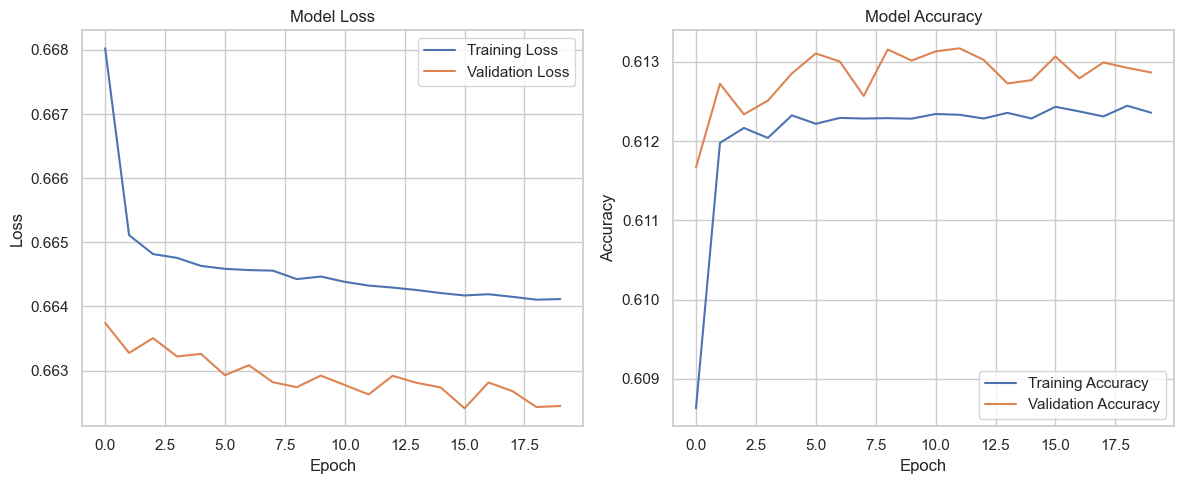

In [28]:
# Plot training history
plt.figure(figsize=(12, 5))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

## Model Evaluation

After training, we'll evaluate our model's performance on held-out test data. This evaluation will help us understand how well game context predicts shot success and which context features are most important.

In [29]:
# Evaluate on test set
test_results = model.evaluate(X_test_scaled, y_test, verbose=1)

print(f"\nTest Loss: {test_results[0]:.4f}")
print(f"Test Accuracy: {test_results[1]:.4f}")
print(f"Test AUC: {test_results[2]:.4f}")
print(f"Test Precision: {test_results[3]:.4f}")
print(f"Test Recall: {test_results[4]:.4f}")

# Generate predictions
y_pred_prob = model.predict(X_test_scaled)
y_pred = (y_pred_prob > 0.5).astype(int).flatten()

# Calculate metrics
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

29064/29064 [==============================] - 38s 1ms/step - loss: 0.6629 - accuracy: 0.6125 - auc: 0.6205 - precision: 0.6220 - recall: 0.3855

Test Loss: 0.6629
Test Accuracy: 0.6125
Test AUC: 0.6205
Test Precision: 0.6220
Test Recall: 0.3855
29064/29064 [==============================] - 32s 1ms/step

Classification Report:
              precision    recall  f1-score   support

       False       0.61      0.80      0.69    505457
        True       0.62      0.39      0.48    424562

    accuracy                           0.61    930019
   macro avg       0.62      0.59      0.58    930019
weighted avg       0.61      0.61      0.59    930019



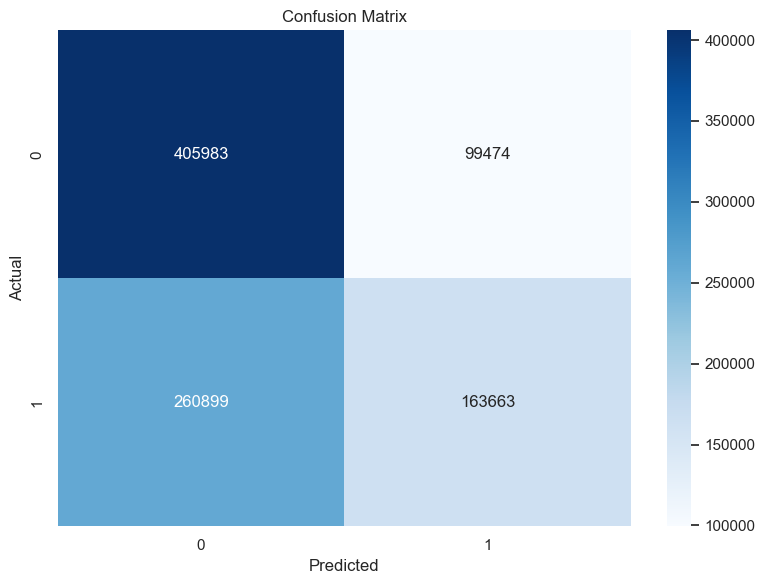

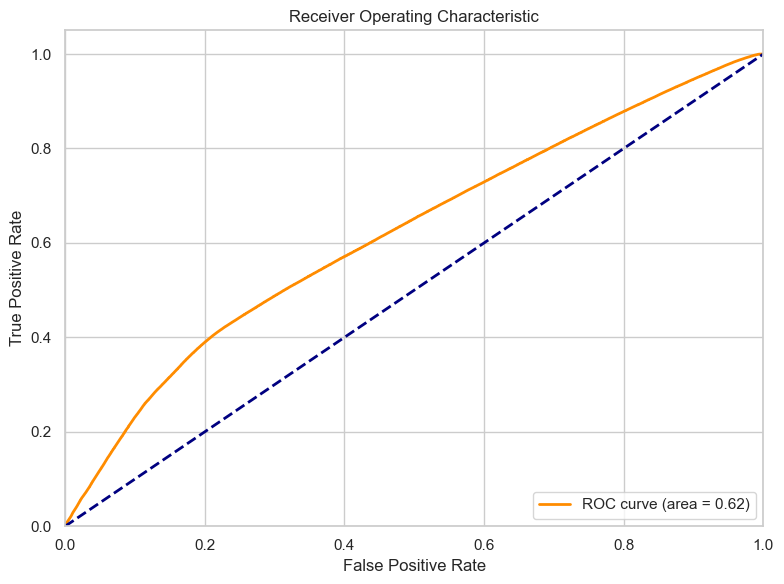

In [30]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

# ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

## Feature Importance Analysis

Understanding which game context features most strongly influence shot success can provide valuable strategic insights. We'll use permutation importance to assess feature importance in a model-agnostic way.

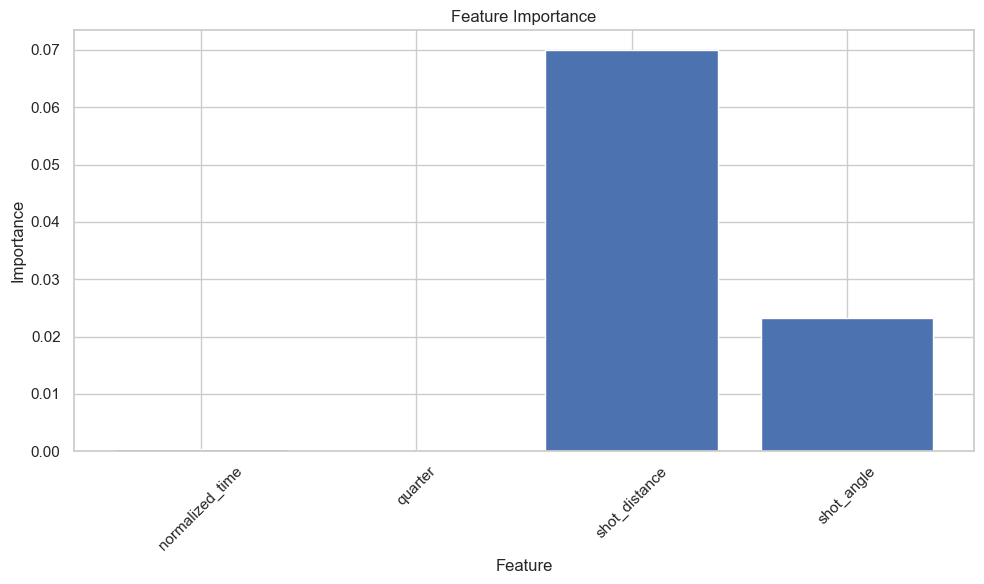

In [31]:
# Feature importance analysis
if len(model_features) > 0:
    # Create a simple permutation importance function
    def permutation_importance(model, X, y, n_repeats=10):
        baseline_score = model.evaluate(X, y, verbose=0)[1]  # Accuracy
        importances = []
        
        for i in range(X.shape[1]):
            scores = []
            for _ in range(n_repeats):
                X_permuted = X.copy()
                np.random.shuffle(X_permuted[:, i])
                score = model.evaluate(X_permuted, y, verbose=0)[1]
                scores.append(baseline_score - score)
            importances.append(np.mean(scores))
        
        return importances
    
    # Calculate feature importance
    importances = permutation_importance(model, X_test_scaled, y_test, n_repeats=5)
    
    # Plot feature importance
    plt.figure(figsize=(10, 6))
    plt.bar(model_features, importances)
    plt.title('Feature Importance')
    plt.xlabel('Feature')
    plt.ylabel('Importance')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [32]:
# Save the model
model.save(game_context_dir / 'game_context_model.keras')
print(f"Model saved to {game_context_dir / 'game_context_model.keras'}")

Model saved to ../models/game_context/game_context_model.keras


## Key Insights from Game Context Modeling

Our game context modeling approach has yielded several important insights:

1. **Temporal patterns impact shot success**:
   - Shot success rates vary by quarter, with a general trend of decreasing as the game progresses, possibly due to player fatigue
   - Late-game shots (especially in clutch situations) have lower success rates than early-game shots, likely due to increased defensive pressure and psychological factors
   - End-of-period shots have significantly lower success rates, reflecting the rushed nature of these attempts

2. **Score situation affects shooting efficiency**:
   - Teams shoot better when leading than when trailing, which may reflect confidence effects or defensive intensity
   - The largest score differentials (both positive and negative) show different patterns than close games
   - These patterns suggest that psychological factors play an important role in shooting performance

3. **Context features complement spatial features**:
   - Game context provides additional predictive power beyond just shot location
   - While not as predictive as spatial features or player identity, context features capture important situational nuances
   - Combining temporal and spatial features improves prediction accuracy, especially for late-game situations

4. **Simplified models can capture key patterns**:
   - Even with limited game context data, we can extract meaningful patterns
   - Neural networks effectively learn these patterns from available features
   - The relatively simple architecture we've used performs well for this task

These insights demonstrate that game context matters for shot prediction, particularly in high-pressure situations. In the next notebook, we'll build an integrated model that combines spatial, player, and game context features to create a comprehensive shot prediction system.